In [1]:
import numpy as np
import torch
from model.gru_audio_model import GRUAudioModel, GRUAudioConfig, top_n_sample
from model.mulaw import mu_law_decode

# Listen or plot
import matplotlib.pyplot as plt
from IPython.display import Audio


In [2]:
rundir="output/synthodd_2025.07.25_15.11"

config_path = rundir+"/config.pt"
ckpt_path = rundir+"/checkpoints/epoch_1000.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
# for generating parameters

def generate_condition_tensor(sr: int, duration: float, *param_specs) -> torch.FloatTensor:
    """
    Generate a [T, p] conditioning parameter tensor.

    Args:
        sr: Sample rate (samples per second)
        duration: Duration in seconds
        *param_specs: One list per parameter:
            [wave_type: str, phase: float (optional), cycles: float, scale: float (optional)]

    Returns:
        Tensor of shape [T, p] with values in [0,1]
    """
    T = int(sr * duration)
    t = np.linspace(0, duration, T, endpoint=False)  # time axis in seconds
    out = []

    for spec in param_specs:
        wave_type = spec[0]
        phase = spec[1] if len(spec) > 1 else 0.0
        cycles = spec[2] if len(spec) > 2 else 1.0
        scale = spec[3] if len(spec) > 3 else 1.0

        freq = cycles / duration
        radians = 2 * np.pi * freq * t + phase

        if wave_type == "sin":
            wave = np.sin(radians)
        elif wave_type == "sawtooth":
            wave = 2 * (radians / (2 * np.pi) % 1) - 1  # ramp from -1 to 1
        elif wave_type == "triangle":
            wave = 2 * np.abs(2 * (radians / (2 * np.pi) % 1) - 1) - 1
        elif wave_type == "square":
            wave = np.sign(np.sin(radians))
        else:
            raise ValueError(f"Unknown wave type: {wave_type}")

        wave = (wave * 0.5 + 0.5) * scale  # Normalize to [0,1] and apply scale
        out.append(wave)

    result = np.stack(out, axis=-1)  # shape [T, p]
    return torch.tensor(result, dtype=torch.float32)

def plot_condition_tensor(cond_tensor: torch.FloatTensor, sr: int):
    """
    Plot conditioning tensor of shape [T, p] with time in seconds on the x-axis.
    """
    T, p = cond_tensor.shape
    time = torch.arange(T) / sr

    plt.figure(figsize=(12, 4))
    for i in range(p):
        plt.plot(time, cond_tensor[:, i], label=f'Param {i+1}')
    
    plt.xlabel("Time (s)")
    plt.ylabel("Normalized value")
    plt.title("Conditioning Parameters")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


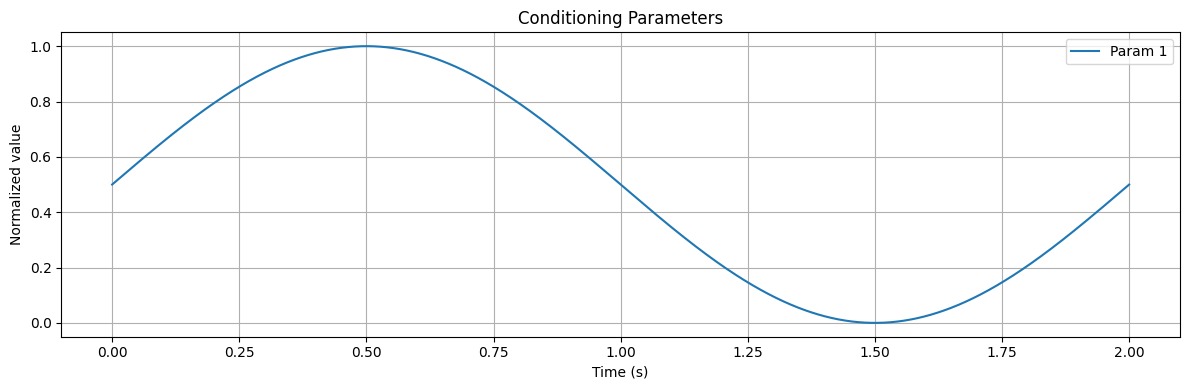

In [4]:
cond_tensor = generate_condition_tensor(16000, 2, ["sin", 0, 1, 1])
plot_condition_tensor(cond_tensor, 16000)

In [5]:
def run_inference(model, cond_seq, warmup_steps=32, top_n=3, seed_token=127):
    """
    model: trained GRUAudioModel (in eval mode, on correct device)
    cond_seq: [T, p] torch.FloatTensor of conditioning parameters
    warmup_steps: int, number of burn-in steps with fixed conditioning
    top_n: use top-N sampling from the logits
    seed_token: mu-law class index (int) for initial input
    """
    device = next(model.parameters()).device
    model.eval()

    T, p = cond_seq.shape
    cond_seq = cond_seq.to(device)
    
    # Create input sequence of mu-law tokens
    total_steps = warmup_steps + T
    generated_classes = []
    
    # Initial input token and hidden state
    prev_token = torch.tensor([[seed_token]], dtype=torch.long, device=device)
    hidden = None

    for t in range(total_steps):
        # Conditioning: use first vector during warmup, then step through sequence
        cond_t = cond_seq[0] if t < warmup_steps else cond_seq[t - warmup_steps]
        cond_t = cond_t.unsqueeze(0).unsqueeze(0)  # [1,1,p]

        logits = model(prev_token, cond_t)        # [1,1,256]
        logits = logits.squeeze(1)                # [1,256]
        next_token = top_n_sample(logits, n=top_n)  # [1]
        generated_classes.append(next_token.item())

        prev_token = next_token.unsqueeze(0)      # [1,1]

    # Decode to waveform
    generated_tensor = torch.tensor(generated_classes[warmup_steps:], dtype=torch.long, device=device)
    audio = mu_law_decode(generated_tensor)  # [T] in [-1,1]
    return audio.cpu().numpy(), generated_classes

In [6]:
from model.gru_audio_model import GRUAudioModel
import torch

In [7]:
!ls "{ckpt_path}"

output/synthodd_2025.07.25_15.11/checkpoints/epoch_1000.pt


In [8]:
# Load model and data config from saved checkpoint

cfg = torch.load(config_path, map_location=device, weights_only=False)
model_config = cfg["model_config"]
data_config = cfg["data_config"]

print(f"device = {device}")
print(f"model_config = {model_config}")
print(f"data_config = {data_config}")

device = cuda
model_config = GRUAudioConfig(num_conditioning_params=1, embedding_dim=8, hidden_size=48, num_layers=3, dropout=0.1)
data_config = AudioDatasetConfig(data_dir='data/MuMeRNN/data/synthodd16', sequence_length=512, parameter_specs={'mp': (52, 76)})


In [9]:
# Build and load model
model = GRUAudioModel(model_config).to(device)
print(f"model = {model}")

model_ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(model_ckpt["model"])
model.eval()


model = GRUAudioModel(
  (embedding): Embedding(256, 8)
  (input_proj): Linear(in_features=9, out_features=48, bias=True)
  (gru): GRU(48, 48, num_layers=3, batch_first=True, dropout=0.1)
  (output_proj): Linear(in_features=48, out_features=256, bias=True)
)


GRUAudioModel(
  (embedding): Embedding(256, 8)
  (input_proj): Linear(in_features=9, out_features=48, bias=True)
  (gru): GRU(48, 48, num_layers=3, batch_first=True, dropout=0.1)
  (output_proj): Linear(in_features=48, out_features=256, bias=True)
)

In [10]:
# Assume model is already loaded and on device
audio_out, class_sequence = run_inference(model, cond_tensor, warmup_steps=32)

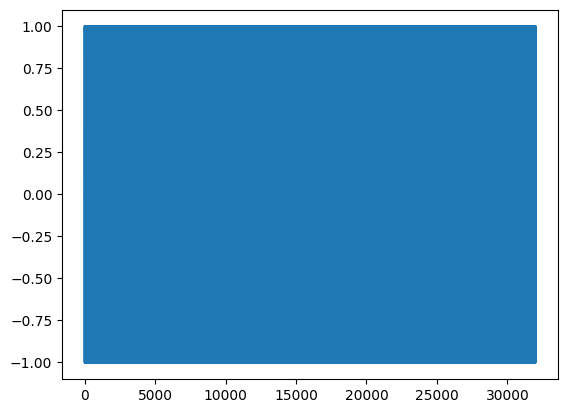

In [11]:
plt.plot(audio_out)
Audio(audio_out, rate=44100)